In [1]:
from moviepy.editor import AudioFileClip
from pytubefix import YouTube
from pytubefix.cli import on_progress
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os

warnings.filterwarnings('ignore')


In [4]:
def download_audio_from_youtube(video_url, output_path, lang = 'english'):
    # Download the YouTube video
    yt = YouTube(video_url, on_progress_callback = on_progress)
    print(f'Title of video{id}: {yt.title}')
    stream = yt.streams.filter(only_audio=True).first()
    stream.download(output_path=output_path)
    
    if lang == 'english':
        caption = yt.captions.get_by_language_code('a.en')
    elif lang == 'spanish':
        caption = yt.captions.get_by_language_code('a.es')

    durations = caption.generate_srt_captions()

    print(f"Video downloaded successfully to {output_path}")
    return yt, caption, durations


In [5]:
# Define the function to extract start and end times from SRT captions
def extract_durations_from_srt(captions_srt):
    # Split captions into blocks
    caption_blocks = captions_srt.strip().split('\n\n')
  
    # Initialize lists to hold the start times, end times, and captions
    start_times = []
    end_times = []
    phrases = []
    
    # Parse each caption block
    for block in caption_blocks:
        lines = block.split('\n')
        if len(lines) >= 3:
            # The time range is on the second line in SRT format
            time_range = lines[1]
            start, end = time_range.split(' --> ')
            
            # The caption text is on the third line
            phrase = ' '.join(lines[2:])
            
            start_times.append(start)
            end_times.append(end)
            phrases.append(phrase)
    
    # Create a DataFrame from the start times, end times, and phrases
    df = pd.DataFrame({
        'Start Time': start_times,
        'End Time': end_times,
        'Phrase': phrases
    })
    return df

In [6]:
OutputFolder = "/Users/sbk/Documents/GitHub/Barryjuait/Personal Projects/Youtube_Analysis"
id = '0001'
video_url = "https://www.youtube.com/watch?v=S_UN4s5qlt8"
video_folder = f"{OutputFolder}/video{id}"
if os.path.isdir(video_folder) == False:
    os.mkdir(video_folder)

# Step 1: Download the video
lang = 'english'
yt, caption, durations = download_audio_from_youtube(video_url, video_folder, lang)

Title of video0001: Neurosurgeon Answers Brain Surgery Questions From Twitter  Tech Support  WIRED
Video downloaded successfully to /Users/sbk/Documents/GitHub/Barryjuait/Personal Projects/Youtube_Analysis/video0001


In [8]:
# Convert the SRT data into a DataFrame
durations_df = extract_durations_from_srt(durations)

# Display the DataFrame
durations_df.head()

,Start Time,End Time,Phrase
0,"00:00:00,000","00:00:05,220",I'm Dr Brian kopel neurosurgeon today
1,"00:00:03,419","00:00:08,109",I'll be answering questions from Twitter
2,"00:00:05,220","00:00:12,439",this is brain surgery support
3,"00:00:08,109","00:00:12,439",[Music]
4,"00:00:12,679","00:00:18,900",if fianel asks what does the brain feel


In [9]:
def find_mp4_file(video_folder):
    files = [f for f in os.listdir(video_folder) if os.path.isfile(os.path.join(video_folder, f))]
    return files[0]

# Find the file
filename = find_mp4_file(video_folder)

In [10]:
import whisper

model = whisper.load_model("medium", device = 'cpu')  # You can choose 'base', "small", "medium", "large" depending on your requirements

100%|█████████████████████████████████████| 1.42G/1.42G [01:21<00:00, 18.7MiB/s]


In [11]:
# Transcribe the audio file and enable word-level timestamps
audioFile = os.path.join(video_folder, filename)
result = model.transcribe(audioFile, word_timestamps=True)

In [15]:
# Prepare lists to hold the word data
words_df= pd.DataFrame()

# Collect start and end times for each word
segments = result['segments']

for ix in range(len(segments)):
    word_info = segments[ix].get('words')
    df = pd.DataFrame(word_info)

    words_df = pd.concat([words_df, df], ignore_index=True)

# Display the DataFrame
print("Words with Start and End Times:")
words_df.head()

Words with Start and End Times:


,word,start,end,probability
0,I'm,0.00,0.42,0.901800
1,Dr.,0.42,0.84,0.944683
2,Brian,0.94,1.28,0.962219
3,"Coppell,",1.28,1.80,0.690753
4,neurosurgeon.,2.00,2.88,0.986870


Intervals between Onsets:
                word    start  interval
1                Dr.     0.42      0.42
2              Brian     0.94      0.52
3           Coppell,     1.28      0.34
4      neurosurgeon.     2.00      0.72
5              Today     3.20      1.20
...              ...      ...       ...
2800             for  1023.94      0.22
2801        watching  1024.20      0.26
2802           Brain  1024.50      0.30
2803         Surgery  1024.86      0.36
2804        Support.  1025.26      0.40

[2804 rows x 3 columns]


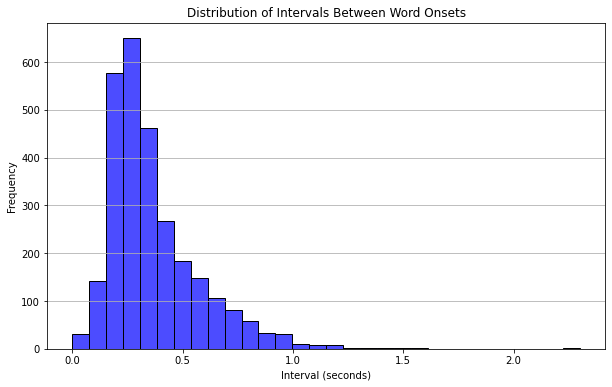

In [14]:
# Ensure columns are in numeric format
words_df['start'] = pd.to_numeric(words_df['start'], errors='coerce')
words_df['end'] = pd.to_numeric(words_df['end'], errors='coerce')

# Calculate the interval between consecutive start times
words_df['interval'] = words_df['start'].diff()

# Drop the first row since it will have NaN for the interval
intervals_df = words_df.dropna(subset=['interval'])

# Display the intervals
print("Intervals between Onsets:")
print(intervals_df[['word', 'start', 'interval']])

# Plot the distribution of intervals
fig, ax = plt.subplots(1,1,figsize=(10, 6))
sns.histplot(intervals_df, x = 'interval', bins=30, alpha=0.7, color='blue')
plt.title('Distribution of Intervals Between Word Onsets')
plt.xlabel('Interval (seconds)')
plt.ylabel('Frequency')
plt.grid(axis='y')
plt.show()